<a href="https://colab.research.google.com/github/Pavel-V/Adaptive_Forecasting/blob/master/Wind_speed_adaptive_forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Применение адаптивных алгоритмов прогнозирования скорости ветра

## 1. Подготовка среды, данных, метрик


### 1.1 Установка и подключение нужных библиотек (пакетов)

In [1]:
# Установка пакета Statsmodels. Из этого пакета будет использован алгоритм Холта-Уинтерса
import sys
!{sys.executable} -m pip install --upgrade statsmodels

Requirement already up-to-date: statsmodels in /usr/local/lib/python3.6/dist-packages (0.9.0)


In [2]:
# Установка пакета MPLD3 для добавления интерактивного функционала графикам
!{sys.executable} -m pip install mpld3

    100% |████████████████████████████████| 798kB 21.9MB/s 
  Stored in directory: /root/.cache/pip/wheels/c0/47/fb/8a64f89aecfe0059830479308ad42d62e898a3e3cefdf6ba28
Successfully built mpld3


In [0]:
 # для чтения csv файла
import pandas as pd
import io

# для быстрой обработки массивов данных
import numpy as np

# для загрузки данных с удаленного сервера
import requests

# для алгоритма Holt-Winters
from statsmodels.tsa.api import ExponentialSmoothing

# для построения графиков
import matplotlib.pyplot as plt
%matplotlib inline
import mpld3
mpld3.enable_notebook()

### 1.2. Получение данных о скорости ветра 

In [0]:
url = "https://www.dropbox.com/s/jtgrei588ow7zpy/WindSpeed.csv?dl=1"
content = requests.get(url).content
input_df = pd.read_csv(io.StringIO(content.decode('utf-8')))

In [12]:
# Скорости ветра записывались каждые три часа.
# Для увеличения выборки данных и прогнозирования на 1 час вперед
# применена интерполяция, между каждыми отсчетами исходного набора данных 
# вставлено по два дополнительных часа, например, в файле данные о 10-м и 13-м часах,
# будут сгенерированы и добавлены данные за 11-й и 12-й час

input_arr = input_df.values
input_arr = np.squeeze(input_arr)

# временный массив для записи расширенных данных
tmp = np.zeros(3 * len(input_arr))

# установка начального значения генератора случайных чисел для получения стабильных результатов
np.random.seed(1)

j = 0
for i in range(0, len(input_arr) - 1):
     # 0-й, 3-й, 6-й, ...  часы как есть
    tmp[j] = input_arr[i]
    
    # 1-й, 4-й, 7-й часы путем интерполяции со случайным искажением (добавлением +.- 10%)
    tmp[j + 1] = (input_arr[i] + (1 * (input_arr[i + 1] - input_arr[i + 1]) / 3)) * np.random.uniform(0.9, 1.1)

    # 2-й, 5-й, 8-й часы путем интерполяции со случайным искажением  (добавлением +.- 10%)
    tmp[j + 2] = (input_arr[i] + (2 * (input_arr[i] - input_arr[i + 1]) / 3)) * np.random.uniform(0.9, 1.1)
    
    j += 3

# вывод размерности полученных массивов
print(input_arr.shape)
print(tmp.shape)

# чтобы данных стало ровно в три раза больше, последний час исходных данных просто
# со случайным искажением  (добавлением +.- 10%)
tmp[-3] = input_arr[-1] * np.random.uniform(0.9, 1.1)
tmp[-2] = input_arr[-1] * np.random.uniform(0.9, 1.1)
tmp[-1] = input_arr[-1] * np.random.uniform(0.9, 1.1)

input_arr = tmp

(975,)
(2925,)


![data_augmentation](https://www.dropbox.com/s/rlgt0i4ctd1illk/data_augmentation.jpg?dl=1 =366x155)

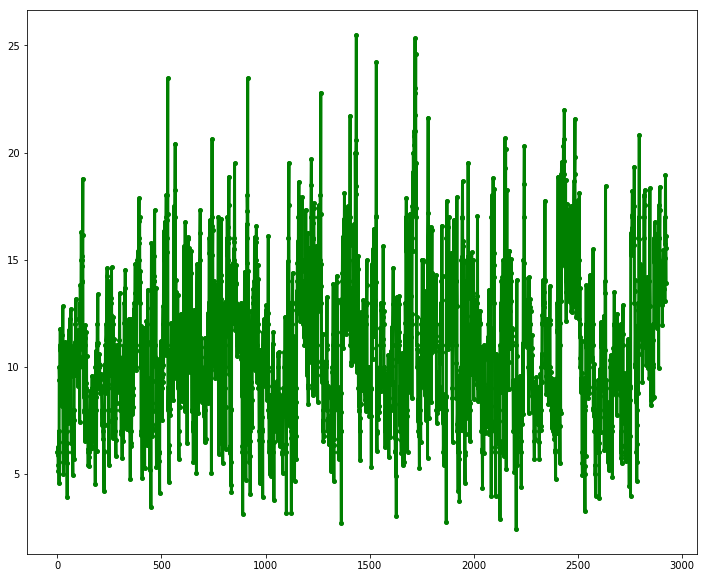

In [13]:
# вывод полученных данных за каждый час на графике
plt.rcParams['figure.figsize'] = [12, 10]
plt.plot(np.arange(len(input_arr)), input_arr, color = 'g', linewidth = 3, markersize = 4,  marker='o')
plt.show()

### 1.3. Разделение данных
Разделение на train (для обучения) и validation (для проверки качества).

In [14]:
# 2/3 на обучение
# 1/3 на валидацию
train_speed = input_arr[0 : 2 * len(input_arr) // 3]
val_speed = input_arr[2 * len(input_arr) // 3 : ]
print(train_speed.shape)
print(val_speed.shape)

(1950,)
(975,)


### 1.4 Метрики для оценки качества прогнозов

In [0]:
# MSE - средний квадрат ошибки
def mse_calc(y_arr, f_arr):
    return ((y_arr - f_arr)**2).mean(axis = None)

# RMSEA - корень из среднего квадрата ошибки  
def rmse_calc(y_arr, f_arr):
    return np.sqrt(mse_calc(y_arr, f_arr))

# MAPE - среднее абсолютное значение ошибки в процентах  
def mape_calc(y_arr, f_arr):
    return (np.abs(y_arr - f_arr) / np.abs(y_arr)).mean(axis = None) * 100.


def print_metrics(train_ground_truth, val_ground_truth, train_forecast, val_forecast):
    print(("RMSE train = " + str(rmse_calc(train_ground_truth, train_forecast)) + "; MAPE train = " + str(mape_calc(train_ground_truth, train_forecast))))
    print(("RMSE val = "   + str(rmse_calc(val_ground_truth  , val_forecast))   + "; MAPE val = "   + str(mape_calc(val_ground_truth  , val_forecast))))

## 2. Алгоритмы прогнозирования и их применение


### 2.1. Реализация адаптивных алгоритмов

In [0]:
#Brown_1 - алгоритм Брауна, простое экспоненциальное сглаживание
def brown_1(input_arr, alpha = 0.1):
    t = len(input_arr)
    s = input_arr[0]
    output_arr = np.zeros(t)
    output_arr[0] = s
    for i in range(1, t):
        output_arr[i] = s
        s = alpha * input_arr[i] + (1. - alpha) * s
        
    return output_arr

In [0]:
#Brown_2 - алгоритм Брауна двойного экспоненциального сглаживания
def brown_2(input_arr, alpha = 0.1):
    t = len(input_arr)
    s1 = input_arr[0]
    s2 = input_arr[0]
    output_arr = np.zeros(t)
    output_arr[0] = s1
    for i in range(1, t):
        a = 2 * s1 - s2
        #b = alpha / (1. - alpha) * (s1 - s2)
        output_arr[i] = a # + 0 * b
        s1 = alpha * input_arr[i] + (1. - alpha) * s1
        s2 = alpha * s1 + (1. - alpha) * s2
        
    return output_arr

In [0]:
#Holt - алгоритм Холта, учитывающий тренд
def holt(input_arr, alpha = 0.1, betta = 0.1):
    t = len(input_arr)
    s = input_arr[1]
    b = input_arr[1] - input_arr[0]
    output_arr = np.zeros(t)
    output_arr[0] = s
    for i in range(1, t):
        output_arr[i] = s
        s_new = alpha * input_arr[i] + (1. - alpha) * (s + b)
        b = betta * (s_new - s) + (1. - betta) * b
        s = s_new
    
    return output_arr

In [0]:
#Holt modif - модификация алгоритма Холта - поле для экспериментов по созданию своих алгоритмов
def holt_m(input_arr, alpha = 0.1, betta = 0.1, gamma = 0.9, l = 5):
    t = len(input_arr)
    s = input_arr[1]
    b = input_arr[1] - input_arr[0]
    output_arr = np.zeros(t)
    output_arr[0] = s
    for i in range(1, t):
        # делается попытка учитывать данные за час из более далекого прошлого  
        if i > l:
            output_arr[i] = s * gamma + input_arr[i - l] * (1. - gamma)
        else:
            output_arr[i] = s
        s_new = alpha * input_arr[i] + (1. - alpha) * (s + b)
        b = betta * (s_new - s) + (1. - betta) * b
        s = s_new
    
    return output_arr

### 2.2. Применение алгоритмов и вывод результатов

Brown_1
RMSE train = 2.3944487542461457; MAPE train = 16.108994464982505
RMSE val = 2.3335444988164658; MAPE val = 15.610137090825054
Brown_2
RMSE train = 2.4601151093364995; MAPE train = 16.240295501462366
RMSE val = 2.4019756900193774; MAPE val = 15.792239212444114
Hold
RMSE train = 2.4102902705712017; MAPE train = 16.296318599165424
RMSE val = 2.3491416594243253; MAPE val = 15.766022508273348
Hold_m
RMSE train = 2.3314672095286264; MAPE train = 16.127488382597697
RMSE val = 2.2716159244526386; MAPE val = 15.60096170758001


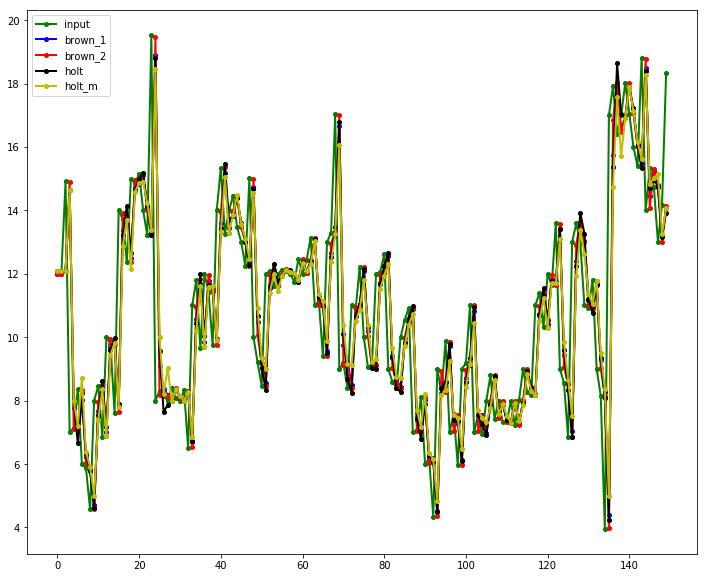

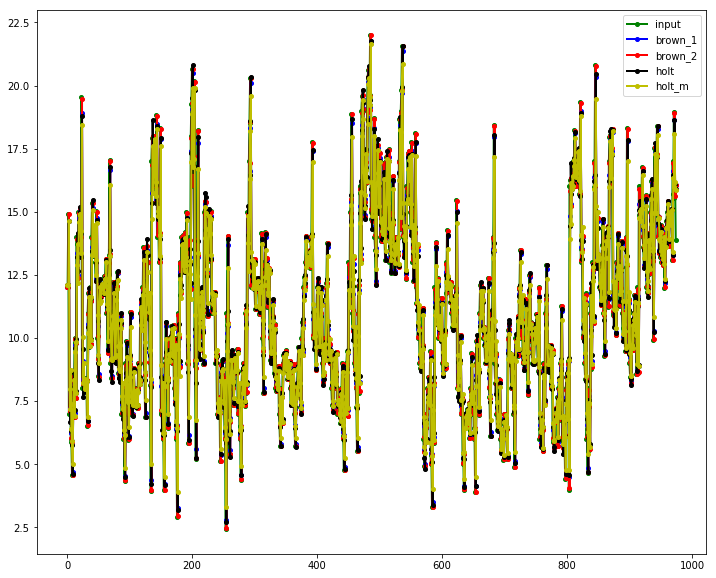

In [22]:
print('Brown_1')
alpha_1 = 0.9
brown_1_arr_train = brown_1(train_speed, alpha_1)
brown_1_arr_val   = brown_1(val_speed, alpha_1)
print_metrics(train_speed, val_speed, brown_1_arr_train, brown_1_arr_val)

print('Brown_2')
alpha_2 = 0.9
brown_2_arr_train = brown_2(train_speed, alpha_2)
brown_2_arr_val   = brown_2(val_speed, alpha_2)
print_metrics(train_speed, val_speed, brown_2_arr_train, brown_2_arr_val)

print('Hold')
alpha_h = 0.9
betta_h = 0.9
holt_arr_train = holt(train_speed, alpha_h, betta_h)
holt_arr_val   = holt(val_speed, alpha_h, betta_h)
print_metrics(train_speed, val_speed, holt_arr_train, holt_arr_val)

print('Hold_m')
alpha_h_m = 0.9
betta_h_m = 0.9
gamma_h_m = 0.9
l_h_m = 4
holt_m_arr_train = holt_m(train_speed, alpha_h_m, betta_h_m, gamma_h_m, l_h_m)
holt_m_arr_val = holt_m(val_speed, alpha_h_m, betta_h_m, gamma_h_m, l_h_m)
print_metrics(train_speed, val_speed, holt_m_arr_train, holt_m_arr_val)


# показ отдельно начального отрезка - в нем меньше данных, чем во всей выборке, поэтому он наглядне 
view_len = 150
plt.plot(np.arange(view_len), val_speed[:view_len]      , color = 'g'    , linewidth = 2, markersize = 4,  marker='o')
plt.plot(np.arange(view_len), brown_1_arr_val[:view_len], color = 'b'    , linewidth = 2, markersize = 4,  marker='o')
plt.plot(np.arange(view_len), brown_2_arr_val[:view_len], color = 'r'    , linewidth = 2, markersize = 4,  marker='o')
plt.plot(np.arange(view_len), holt_arr_val[:view_len]   , color = 'black', linewidth = 2, markersize = 4,  marker='o')
plt.plot(np.arange(view_len), holt_m_arr_val[:view_len]   , color = 'y'  , linewidth = 2, markersize = 4,  marker='o')


plt.legend(['input', 'brown_1', 'brown_2', 'holt', 'holt_m'])
plt.rcParams["figure.figsize"] = [12, 10]
plt.show() 

# показ всего графика валидационной выборки
plt.plot(np.arange(len(val_speed)), val_speed      , color = 'g'    , linewidth = 2, markersize = 4,  marker='o')
plt.plot(np.arange(len(val_speed)), brown_1_arr_val, color = 'b'    , linewidth = 2, markersize = 4,  marker='o')
plt.plot(np.arange(len(val_speed)), brown_2_arr_val, color = 'r'    , linewidth = 2, markersize = 4,  marker='o')
plt.plot(np.arange(len(val_speed)), holt_arr_val   , color = 'black', linewidth = 2, markersize = 4,  marker='o')
plt.plot(np.arange(len(val_speed)), holt_m_arr_val , color = 'y'    , linewidth = 2, markersize = 4,  marker='o')

plt.legend(['input', 'brown_1', 'brown_2', 'holt', 'holt_m'])
plt.rcParams["figure.figsize"] = [12, 10]
plt.show()

### 2.3. Применение сторонней реализации алгоритма Холта-Уинтерса
Учитывает сезонность (периодичность)

Hold-Winters
RMSE train = 2.897661667812819; MAPE train = 19.731450232411003
RMSE val = 2.9996240426549874; MAPE val = 20.958695583868913


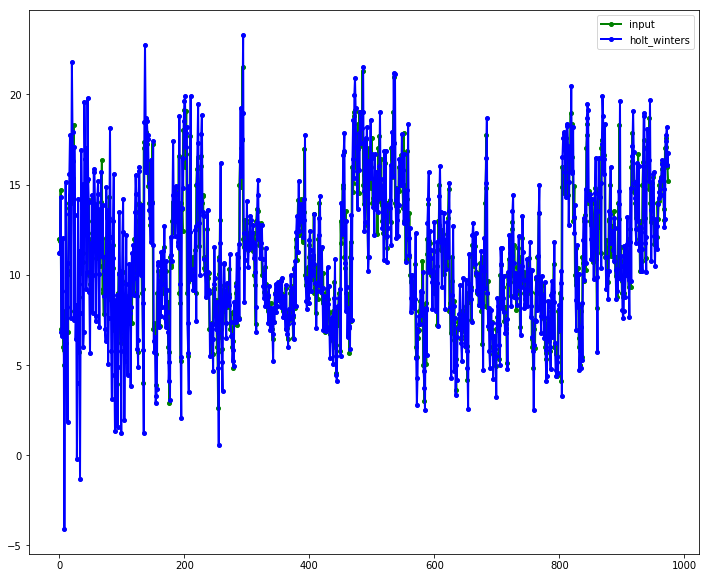

In [0]:
print('Hold-Winters')

fit1 = ExponentialSmoothing(train_speed, seasonal_periods = 5, trend='add', seasonal='add').fit(smoothing_level = 0.8, smoothing_slope = 0.5, smoothing_seasonal = 0.05, optimized = False)

holt_wint_arr_train = fit1.fittedvalues

# from statsmodels.tsa.api.
fit1 = ExponentialSmoothing(val_speed, seasonal_periods = 5, trend='add', seasonal='add').fit(smoothing_level = 0.8, smoothing_slope = 0.5, smoothing_seasonal = 0.05, optimized = False)

holt_wint_arr_val = fit1.fittedvalues


print_metrics(train_speed, val_speed, holt_wint_arr_train, holt_wint_arr_val)

plt.plot(np.arange(len(val_speed)), val_speed        , color = 'g'    , linewidth = 2, markersize = 4,  marker='o')
plt.plot(np.arange(len(val_speed)), holt_wint_arr_val, color = 'b'    , linewidth = 2, markersize = 4,  marker='o')

plt.legend(['input', 'holt_winters'])
plt.rcParams["figure.figsize"] = [12, 10]
plt.show()